<a href="https://colab.research.google.com/github/shailavij/NLP/blob/master/ATIS_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install seqeval==0.0.12

     |████████████████████████████████| 133kB 15.2MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 133kB 32.0MB/s 
     |████████████████████████████████| 6.9MB 46.7MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
ERROR: botocore 1.19.25 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


# Intent Classification With BERT Model

In [4]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
from google.colab import files
uploaded = files.upload()

Saving atis.test.w-intent.iob to atis.test.w-intent.iob
Saving atis.train.w-intent.iob to atis.train.w-intent.iob
Saving atis-2.dev.w-intent.iob to atis-2.dev.w-intent.iob
Saving atis-2.train.w-intent.iob to atis-2.train.w-intent.iob


In [6]:
#preprocessing functions
def get_data(filename):
    df = pd.read_csv(filename,delim_whitespace=True,names=['word','label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents,labels,intents = [],[],[]
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return np.array(sents),np.array(labels),np.array(intents)

def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents,labels,intents = [],[],[]
    for line in contents.strip().split('\n'):
        words,labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return np.array(sents),np.array(labels),np.array(intents)

read_method = {'atis-2.dev.w-intent.iob':get_data,
               'atis.train.w-intent.iob':get_data2,
               'atis.test.w-intent.iob':get_data,
              'atis-2.train.w-intent.iob':get_data2}

def fetch_data(fname):
    func = read_method[fname]
    return func(fname)

In [7]:
print("Loading the training Data")
sents,labels,intents = fetch_data('atis.train.w-intent.iob')

train_sentences = [" ".join(i) for i in sents]

train_texts = train_sentences
train_labels= intents.tolist()

vals = []

for i in range(len(train_labels)):
    if "#" in train_labels[i]:
        vals.append(i)
        
for i in vals[::-1]:
    train_labels.pop(i)
    train_texts.pop(i)

print ("Number of training sentences :",len(train_texts))
print ("Number of unique intents :",len(set(train_labels)))

for i in zip(train_texts[:5], train_labels[:5]):
    print(i)

Loading the training Data
Number of training sentences : 4952
Number of unique intents : 17
('i want to fly from boston at 838 am and arrive in denver at 1110 in the morning', 'atis_flight')
('what flights are available from pittsburgh to baltimore on thursday morning', 'atis_flight')
('what is the arrival time in san francisco for the 755 am flight leaving washington', 'atis_flight_time')
('cheapest airfare from tacoma to orlando', 'atis_airfare')
('round trip fares from pittsburgh to philadelphia under 1000 dollars', 'atis_airfare')


In [8]:
# from utils import fetch_data, read_method

sents,labels,intents = fetch_data('atis.test.w-intent.iob')

test_sentences = [" ".join(i) for i in sents]

test_texts = test_sentences
test_labels = intents.tolist()

new_labels = set(test_labels) - set(train_labels)

vals = []

for i in range(len(test_labels)):
    if "#" in test_labels[i]:
        vals.append(i)
    elif test_labels[i] in new_labels:
        print(test_labels[i])
        vals.append(i)
        
for i in vals[::-1]:
    test_labels.pop(i)
    test_texts.pop(i)

print ("Number of testing sentences :",len(test_texts))
print ("Number of unique intents :",len(set(test_labels)))

for i in zip(test_texts[:5], test_labels[:5]):
    print(i)

atis_day_name
atis_day_name
Number of testing sentences : 876
Number of unique intents : 15
('i would like to find a flight from charlotte to las vegas that makes a stop in st. louis', 'atis_flight')
('on april first i need a ticket from tacoma to san jose departing before 7 am', 'atis_airfare')
('on april first i need a flight going from phoenix to san diego', 'atis_flight')
('i would like a flight traveling one way from phoenix to san diego on april first', 'atis_flight')
('i would like a flight from orlando to salt lake city for april first on delta airlines', 'atis_flight')


In [9]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame(data =zip(train_labels,train_texts),columns=['Labels',"Text"])

lb_make = LabelEncoder()
df["Labels"] = lb_make.fit_transform(df["Labels"])

train_texts = list(df['Text'])
train_labels = list(df['Labels'])
print("Length of training labels:",len(train_labels))
print("Length of training texts:",len(train_texts))

Length of training labels: 4952
Length of training texts: 4952


In [11]:
#BERT expects data to be in a specific format, i.e, [CLS] token1,token2,....[SEP]

In [12]:
query_data_train = list(train_texts)
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

[CLS] i want to fly from boston at 838 am and arrive in denver at 1110 in the morning [SEP]


In [13]:
# Tokenize with BERT tokenizer

#BERT only takes a token size of 512.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 21519767.09B/s]


Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [14]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Creating the BERT attention masks

In [15]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [21]:
 #Use train_test_split to split our data into train and validation sets for training

intent_data_label_train = train_labels#renaming 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,intent_data_label_train, random_state=2020,test_size=0.1)
                                                                              
                                                                                         
                                                                                        
train_masks, validation_masks, _, _ = train_test_split(attention_masks,input_ids,random_state=2020,test_size=0.1)
                                                        
                                                       
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=17)
model.cuda()

100%|██████████| 407873900/407873900 [00:05<00:00, 70550905.04B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.49403373758042496


Epoch:  25%|██▌       | 1/4 [02:05<06:17, 125.93s/it]

Validation Accuracy: 0.974609375
Train loss: 0.11731672785577497


Epoch:  50%|█████     | 2/4 [04:13<04:12, 126.29s/it]

Validation Accuracy: 0.982421875
Train loss: 0.07327706597196604


Epoch:  75%|███████▌  | 3/4 [06:20<02:06, 126.60s/it]

Validation Accuracy: 0.986328125
Train loss: 0.040089803485066765


Epoch: 100%|██████████| 4/4 [08:27<00:00, 126.93s/it]

Validation Accuracy: 0.994140625


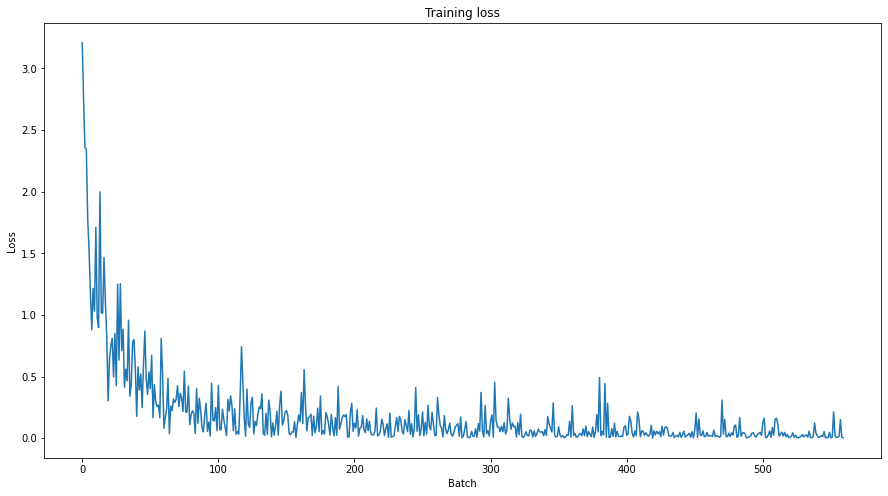

In [23]:
# BERT fine-tuning parameters
FULL_FINETUNING = True
if FULL_FINETUNING:
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = BertAdam(optimizer_grouped_parameters, lr=3e-5)



# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ###### TRAINING ######
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ###### VALIDATION ######

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()